In [1]:
#import necessary packages

#our workhorses
import numpy as np
import pandas as pd
import scipy

#to visualize
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
#style params for figures
sns.set(font_scale = 2)
plt.style.use('seaborn-white')
plt.rc("axes", labelweight="bold")
from IPython.display import display, HTML

#to load files
import os
import h5py

#for stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multitest as multitest
import statsmodels.stats.multicomp

#load custon functions
import sys

from limb_position_EMG.utils import *

AttributeError: module 'limb_position_EMG.utils' has no attribute 'apply_mv_and_get_f1_scorepermute_class_blocks'

In [9]:
results_folder = '../results_data/xsubject_transform_module/log_reg'

results_df = []
for model_id in range(1,7+1):
    # load model results
    results_fn = 'model_%02d_results.h5'%(model_id)
    model_df = pd.read_hdf(os.path.join(results_folder,results_fn), 'results_df')
    model_df['Model'] = model_id
    #append to collective dataframe
    results_df.append(model_df)
results_df = pd.concat(results_df,axis = 0)

In [10]:
# Average over multiple train/test splits of the data
results_df = results_df.groupby(['Shuffled','Type','Model','Rep_all'],as_index = False)\
.mean()\
.drop(columns = ['Fold','Rep_subject_order'])

In [11]:
results_df.head()

,Shuffled,Type,Model,Rep_all,F1_score,Subject
0,False,Train,1,1,0.967083,20.612903
1,False,Train,1,2,0.966450,20.612903
2,False,Train,1,3,0.966522,20.612903
3,False,Train,1,4,0.966650,20.612903
4,False,Train,1,5,0.966553,20.612903


In [12]:
train_results_df = results_df.loc[results_df.Type == 'Train']
test_results_df = results_df.loc[results_df.Type == 'Val_Test']

train_summary = train_results_df.groupby(['Shuffled','Model']).mean().\
drop(columns=['Rep_all']).\
rename(columns={'F1_score':'Train_score'})

test_summary = test_results_df.groupby(['Shuffled','Model']).mean().\
drop(columns=['Rep_all']).\
rename(columns={'F1_score':'Test_score'})

summary_df = pd.concat([train_summary,test_summary],axis = 1)
summary_df

Train_score    Subject  Test_score    Subject
Shuffled Model                                               
False    1         0.966647  20.612903    0.917887  20.612903
         2         0.967989  20.612903    0.917868  20.612903
         3         0.964762  20.612903    0.903537  20.612903
         4         0.960066  20.612903    0.909244  20.612903
         5         0.939196  20.612903    0.858719  20.612903
         6         0.937512  20.612903    0.873157  20.612903
         7         0.805389  20.612903    0.689775  20.612903
True     1         0.214783  20.612903    0.146033  20.612903
         2         0.221796  20.612903    0.145643  20.612903
         3         0.226978  20.612903    0.141785  20.612903
         4         0.197418  20.612903    0.134146  20.612903
         5         0.163180  20.612903    0.118813  20.612903
         6         0.169504  20.612903    0.122917  20.612903
         7         0.107831  20.612903    0.091261  20.612903

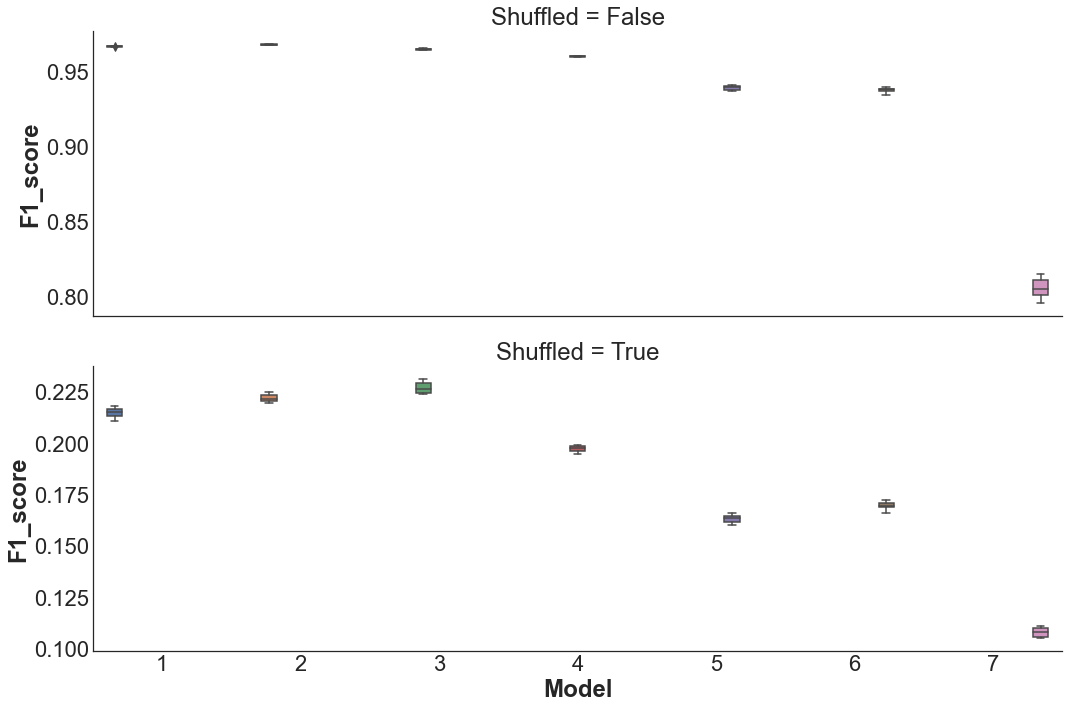

In [14]:
g = sns.catplot(data = train_results_df, x= 'Model', y = 'F1_score', col = 'Shuffled', hue = 'Model',\
            kind = 'box', col_order = [False,True], col_wrap = 1, aspect = 3, sharey = False)

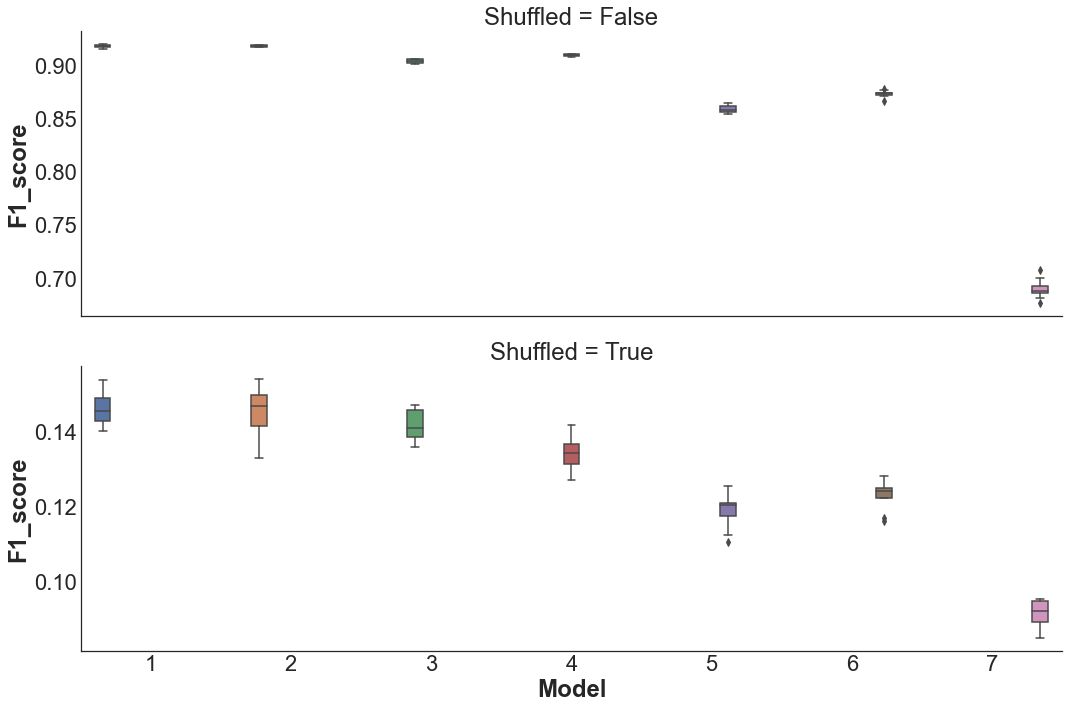

In [15]:
g = sns.catplot(data = test_results_df, x= 'Model', y = 'F1_score', col = 'Shuffled', hue = 'Model',\
            kind = 'box', col_order = [False,True], col_wrap = 1, aspect = 3, sharey = False)

In [16]:
results_true_df = results_df.loc[results_df.Shuffled == False]

In [17]:
# Run ANOVA
model = ols('F1_score ~ C(Model)*C(Type)', results_true_df).fit()

# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
res

,sum_sq,df,F,PR(>F)
C(Model),0.998774,6.0,12326.439595,3.653852e-242
C(Type),0.179158,2.0,6633.265161,8.800616e-176
C(Model):C(Type),0.025358,12.0,156.476253,3.099381e-91
Residual,0.002552,189.0,NaN,NaN


In [18]:
groups =  results_true_df['Model'].map(str) + ' - ' + results_true_df['Type'].map(str)

mc = statsmodels.stats.multicomp.MultiComparison(results_true_df['F1_score'],groups)
mc_results = mc.tukeyhsd()
print(mc_results)


       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1        group2    meandiff p-adj   lower   upper  reject
------------------------------------------------------------------
    1 - Train  1 - Val_Test  -0.0488  0.001 -0.0547 -0.0428   True
    1 - Train 1 - Val_Train    0.004 0.6268 -0.0019    0.01  False
    1 - Train     2 - Train   0.0013    0.9 -0.0046  0.0073  False
    1 - Train  2 - Val_Test  -0.0488  0.001 -0.0547 -0.0428   True
    1 - Train 2 - Val_Train   0.0051 0.2053 -0.0009  0.0111  False
    1 - Train     3 - Train  -0.0019    0.9 -0.0078  0.0041  False
    1 - Train  3 - Val_Test  -0.0631  0.001 -0.0691 -0.0572   True
    1 - Train 3 - Val_Train  -0.0009    0.9 -0.0068  0.0051  False
    1 - Train     4 - Train  -0.0066  0.014 -0.0125 -0.0006   True
    1 - Train  4 - Val_Test  -0.0574  0.001 -0.0634 -0.0515   True
    1 - Train 4 - Val_Train  -0.0061 0.0415  -0.012 -0.0001   True
    1 - Train     5 - Train  -0.0275  0.001 -0.0334 -0.0215   

In [19]:
test_results_true_df = results_df.loc[(results_df.Type == 'Val_Test')&(results_df.Shuffled == False)]
train_results_true_df = results_df.loc[(results_df.Type == 'Train')&(results_df.Shuffled == False)]


In [20]:
# Run ANOVA
model = ols('F1_score ~ C(Model)', test_results_true_df).fit()

# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
res

,sum_sq,df,F,PR(>F)
C(Model),0.398114,6.0,4245.428467,3.872225e-80
Residual,0.000985,63.0,NaN,NaN


In [21]:
groups =  test_results_true_df['Model'].map(str) #+ ' - ' + test_results_true_df['Shuffled'].map(str)

mc = statsmodels.stats.multicomp.MultiComparison(test_results_true_df['F1_score'],groups)
mc_results = mc.tukeyhsd()
print(mc_results)

#p_values = psturng(np.abs(mc_results.meandiffs / mc_results.std_pairs), len(mc_results.groupsunique), mc_results.df_total)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2     -0.0    0.9 -0.0054  0.0054  False
     1      3  -0.0143  0.001 -0.0197  -0.009   True
     1      4  -0.0086  0.001  -0.014 -0.0033   True
     1      5  -0.0592  0.001 -0.0646 -0.0538   True
     1      6  -0.0447  0.001 -0.0501 -0.0393   True
     1      7  -0.2281  0.001 -0.2335 -0.2227   True
     2      3  -0.0143  0.001 -0.0197 -0.0089   True
     2      4  -0.0086  0.001  -0.014 -0.0032   True
     2      5  -0.0591  0.001 -0.0645 -0.0538   True
     2      6  -0.0447  0.001 -0.0501 -0.0393   True
     2      7  -0.2281  0.001 -0.2335 -0.2227   True
     3      4   0.0057 0.0309  0.0003  0.0111   True
     3      5  -0.0448  0.001 -0.0502 -0.0394   True
     3      6  -0.0304  0.001 -0.0358  -0.025   True
     3      7  -0.2138  0.001 -0.2191 -0.2084   True
     4      5  -0.0505  0.001 -0.0559 -0.0451 

In [ ]:
X = results_df.loc[(results_df.Type == 'Train')&(results_df.Type == 'Test')]